In [1]:
from IPython.core.display import display, Markdown, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

/tmp/ipykernel_31928/2408481758.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, Markdown, HTML


In [2]:
# %matplotlib inline
%matplotlib inline
from bact_analysis_bessyii.bba.calc import load_calib_data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

# Quadrupole calibration factors check

Checks for the calibration factors. Results found

* Similar in size: thus correspond to mid field strength of an rectangular model
* 

Technical data. Source:


* Quadrupole radius: 35 mm " Technischer Bericht BESSY TB 210/97 April 1997"
* Number of windings: Peter's hand note

    * 28 for the main coil
    * 75 for the muxer helper coil


## Load Data

In [3]:
calib = load_calib_data()

In [4]:
calib;

## First consistency checks 

Data as retrieved: but these should be absolute values: the difference is quite large . Furthermore it is checked that 

* hw2phys
* phys2hw

are the inverse values as expected.

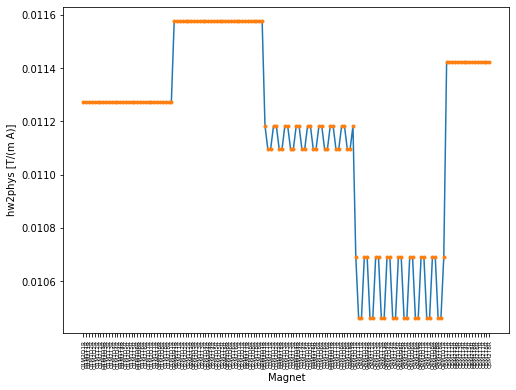

In [5]:
fig, ax = plt.subplots(1,1, figsize=[8, 6])
ax.plot(
    np.absolute(calib.hw2phys), '-'    ,
    np.absolute(1./calib.phys2hw), '.'
)
ax.set_xlabel('Magnet')
ax.set_ylabel('hw2phys [T/(m A)]')
[tick.set_rotation('vertical') for tick in ax.get_xmajorticklabels()]
plt.xticks(fontsize='xx-small');

In [6]:
tick = ax.get_xmajorticklabels()[0]

In [7]:
tick.set_rotation('vertical')

Relative difference: variation of roughly -6 to  4 % expected

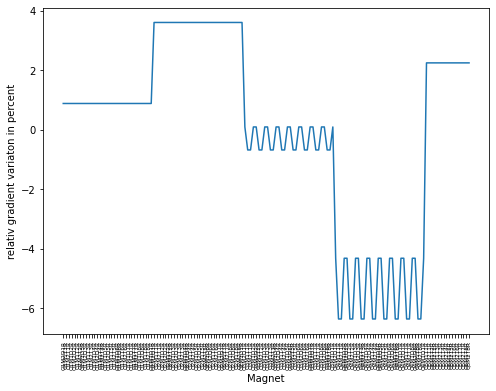

In [8]:
fig, ax = plt.subplots(1,1, figsize=[8, 6])
qhw2p = np.absolute(calib.hw2phys)
ax.plot((qhw2p/qhw2p.mean()-1)*100)
ax.set_xlabel('Magnet')
ax.set_ylabel('relativ gradient variaton in percent');
[tick.set_rotation('vertical') for tick in ax.get_xmajorticklabels()];
plt.xticks(fontsize='xx-small');

Variation with length. Expected difference for the different length

* 200: +2 - +4 percent
* 250: +1 - -1 precent
* 500: -4 - -6 precent

Assuming uniform steel properties for all magnets one would assume that the longer magnets would show a slightly stronger gradient. 

In [9]:
calib;

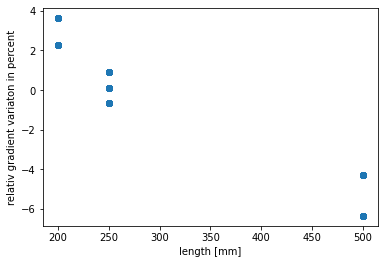

In [10]:
idx = calib.length.argsort()
length = calib.length[idx.values]
strength = qhw2p.isel(name=idx.values)
fig, ax = plt.subplots(1,1)

ax.plot(length*1000, (strength/strength.mean()-1) *100, 'o')
ax.set_xlabel('length [mm]')
ax.set_ylabel('relativ gradient variaton in percent');

### Cross check with ideal number of laminations

$$
   \frac{G r^2}  {2 \mu_0} = N I
$$

$$
G  = 2 \mu_0\frac{N I}{r^2}
$$

In [11]:
mu0 = 4 * np.pi * 1e-7

def calculate_gradient(*, r, N, I):
    G = 2 * mu0 * (N * I) / r**2
    return G

In [12]:

r = 35e-3
Nturns = 28



In [13]:
calculate_gradient(r=r,N=75,I=5)

0.7693696294505614

Peter's hand note gfives a value of $\approx$ 0.769 T/m for 5 A

### Calculating B rho

Radius is given in the sql table

In [14]:
rho = 4.354


$$
    \frac {1}{\rho} = \frac{q}{p_0} B_0
$$

$$
    B_0 = \frac{p_0}{q}\frac 1 \rho
$$

In [15]:
import scipy.constants

In [16]:
1.7e9 / 511e3

3326.8101761252447

In [17]:
Brho = scipy.constants.electron_mass * 3327 * scipy.constants.speed_of_light / scipy.constants.elementary_charge
B0 = Brho / rho
B0 = 1.29932
Brho, B0

(5.670901522937039, 1.29932)

In [18]:
Brho = B0 * rho

Gradient per turn and per Amp

In [19]:
GpN = 2 * mu0 / r**2
Gp = GpN * Nturns
GpN, Gp

(0.0020516523452014973, 0.05744626566564193)

In [20]:
Brho

5.657239280000001

According to Peter's hand note

In [21]:
Brho = 5.67044

In [22]:
1/(qhw2p.sel(name="Q4M1T2R") / (Gp))

<xarray.DataArray 'hw2phys' ()>
array(5.49136488)
Coordinates:
    index    <U7 'Q4M1T2R'
    name     <U7 'Q4M1T2R'

In [23]:
qhw2p.mean() * Brho / Gp

<xarray.DataArray 'hw2phys' ()>
array(1.1027167)

### Checking hardware 2 physics to ideal value

Hardware to physics allows deriving the K value from the excitation current

The ideal value is expected to be larger than the real one as it neglects the magnetic resistance of the return yoke.
In the plot below one can see that all values are larger than the central one. 

It is assumed that the mechanical yoke length was used for the rectangular approximation, thus 
neglecting the "coil's contribution". 


One can see that the value
* vary strongly from family to family
* vary for magnet 1 or magnet 2 (result of sorting)

It is assumed that an average value was derived for the different magnets.

In [24]:
krel_ideal = qhw2p * (Brho /Gp)

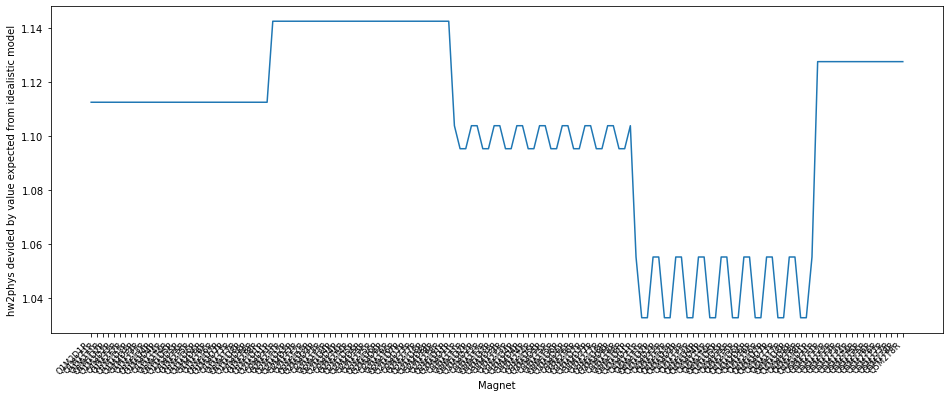

In [25]:
fig, ax = plt.subplots(1,1, figsize=[16, 6])
ax.plot((krel_ideal))
ax.set_xlabel('Magnet')
ax.set_ylabel('hw2phys devided by value expected from idealistic model');
# [tick.set_rotation('vertical') for tick in ax.get_xmajorticklabels()];

def align(tick):
    tick.set_rotation(45) 
    tick.set_verticalalignment('top')
    tick.set_horizontalalignment('right')
    
[align(tick) for tick in ax.get_xmajorticklabels()];
plt.xticks(fontsize='small');

In [26]:
tick = ax.get_xmajorticklabels()[0]

In [27]:
tick.set_horizontalalignment

<bound method Text.set_horizontalalignment of Text(0, 0, 'Q1M2D1R')>

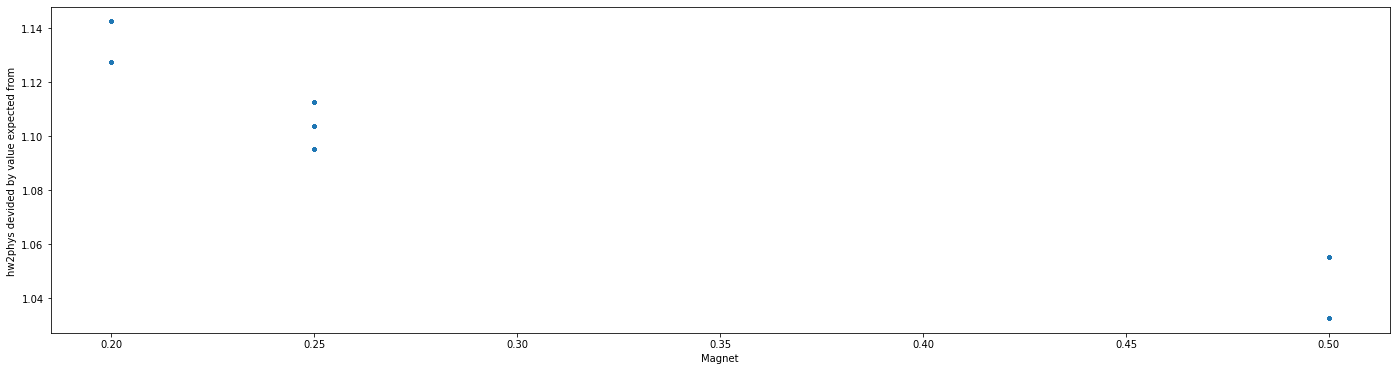

In [28]:
fig, ax = plt.subplots(1,1, figsize=[24, 6])
ax.plot(calib.length, krel_ideal, '.')
ax.set_xlabel('Magnet')
ax.set_ylabel('hw2phys devided by value expected from ');
# [tick.set_rotation('vertical') for tick in ax.get_xmajorticklabels()];
# plt.xticks(fontsize='xx-small');

### New heading

### Cross check by database

There is a second database providing data for different magnets. This sql based database is crosschecked to the data provided by the mongo database

In [29]:
import bact2_bessyii.magnets

In [30]:
df =  bact2_bessyii.magnets.quadrupole_calibration_factors().set_index("name")
df.head()

,name_key,device_name,application,t,i_s,alpha,beta,delta,al,bl,cl,dl,device_key,device_application_key
name,,,,,,,,,,,,,,
Q1M1D1R,1307,Q1M1D1R,CG-lib,0.016612,500.0,4.6907,1.600000e-07,-0.0325,0.27291,0.000179,-3.140000e-07,-1.210000e-09,1631,1
Q1M1D2R,1055,Q1M1D2R,CG-lib,0.016612,500.0,4.6907,1.600000e-07,-0.0325,0.27291,0.000179,-3.140000e-07,-1.210000e-09,2072,1
Q1M1D3R,1091,Q1M1D3R,CG-lib,0.016612,500.0,4.6907,1.600000e-07,-0.0325,0.27291,0.000179,-3.140000e-07,-1.210000e-09,1547,1
Q1M1D4R,1127,Q1M1D4R,CG-lib,0.016612,500.0,4.6907,1.600000e-07,-0.0325,0.27291,0.000179,-3.140000e-07,-1.210000e-09,2020,1
Q1M1D5R,1163,Q1M1D5R,CG-lib,0.016612,500.0,4.6907,1.600000e-07,-0.0325,0.27291,0.000179,-3.140000e-07,-1.210000e-09,1491,1


In [31]:
calib_sql = xr.Dataset.from_dataframe(df)
calib_sql;

The parameter "al" seems to correspond to the length

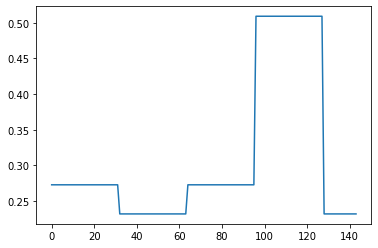

In [32]:
fig, ax = plt.subplots(1, 1, )
ax.plot(calib_sql.al)

In [33]:
tf = calib_sql.t / calib_sql.al

Division yields that the transfer function is pretty uniform

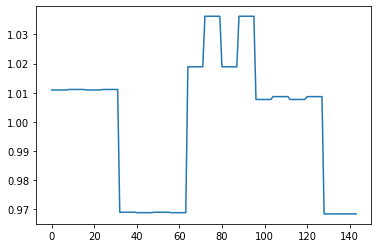

In [34]:
fig, ax = plt.subplots(1, 1, )
ax.plot(tf/tf.mean())

Comparison of the "central" transfer function

Text(0, 0.5, 'r$k_1$ * B $\\rho$ [T/M A]')

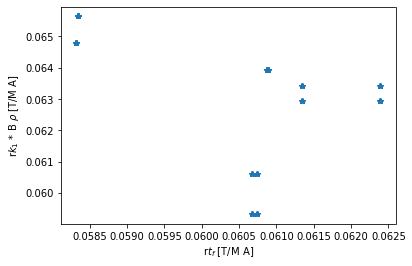

In [35]:
fig, ax = plt.subplots(1, 1, )
ax.plot(tf, qhw2p * Brho, '*')
ax.set_xlabel(r'r$t_f$ [T/M A]')
ax.set_ylabel(r'r$k_1$ * B $\rho$ [T/M A]')

Comparison of the transfer function ratio for the different magnets

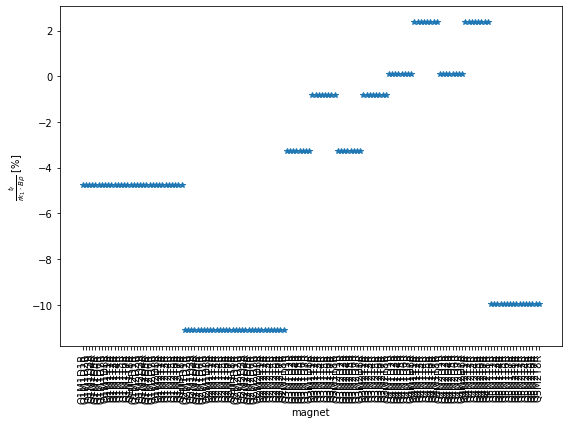

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot((tf / (qhw2p * Brho) -1) * 100, '*')
ax.set_xlabel('magnet')
ax.set_ylabel(r'$\frac{t_f}{rk_1 \cdot B \rho}$ [%]')
[tick.set_rotation('vertical') for tick in ax.get_xmajorticklabels()];
#plt.xticks(fontsize='xx-small');
fig.tight_layout()

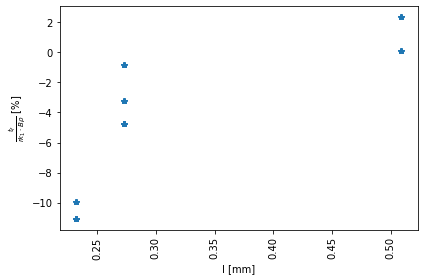

In [37]:
fig, ax = plt.subplots(1, 1)
ax.plot(calib_sql.al, (tf / (qhw2p * Brho) -1) * 100, '*')
ax.set_xlabel('l [mm]')
ax.set_ylabel(r'$\frac{t_f}{rk_1 \cdot B \rho}$ [%]')
[tick.set_rotation('vertical') for tick in ax.get_xmajorticklabels()];
#plt.xticks(fontsize='xx-small');
fig.tight_layout()

In [38]:
def corresponding_length(length):
    l200 = (length>0.23) & (length<0.235)
    l250 = (length>0.27) & (length<0.275)
    l500 = (length>0.5 ) & (length<0.51)
    
    check = l200 + l250 + l500
    assert((check == 1).all())
    
    nl = xr.DataArray(dims=length.dims, coords=length.coords)
    nl.loc[dict(name=l200)] = 0.2
    nl.loc[dict(name=l250)] = 0.25
    nl.loc[dict(name=l500)] = 0.5
    return nl

In [39]:
mechanical_length = corresponding_length(calib_sql.al)

In [40]:
set(list(calib_sql.al.values))

{0.23211, 0.27291000000000004, 0.5091100000000001}

In [41]:
tfm = calib_sql.t / mechanical_length

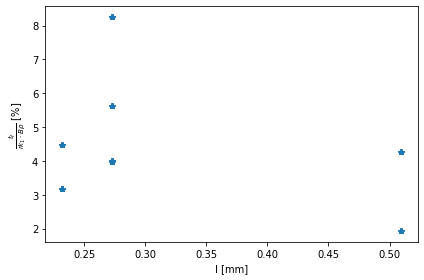

In [42]:
fig, ax = plt.subplots(1, 1)
ax.plot(calib_sql.al, (tfm / (qhw2p * Brho) -1) * 100, '*')
ax.set_xlabel('l [mm]')
ax.set_ylabel(r'$\frac{t_f}{rk_1 \cdot B \rho}$ [%]')
#[tick.set_rotation('vertical') for tick in ax.get_xmajorticklabels()];
#plt.xticks(fontsize='xx-small');
fig.tight_layout()

## AT Measurement data 

In [43]:
 txt = """(QUAD) Fit parameter:   1, Name : Q1M2D1R, value:  2.434852  1/m^2
   (QUAD) Fit parameter:   2, Name : Q1M1T1R, value:  2.432500  1/m^2
   (QUAD) Fit parameter:   3, Name : Q1M2T1R, value:  2.438276  1/m^2
   (QUAD) Fit parameter:   4, Name : Q1M1D2R, value:  2.428871  1/m^2
   (QUAD) Fit parameter:   5, Name : Q1M2D2R, value:  2.430467  1/m^2
   (QUAD) Fit parameter:   6, Name : Q1M1T2R, value:  2.434239  1/m^2
   (QUAD) Fit parameter:   7, Name : Q1M2T2R, value:  2.428813  1/m^2
   (QUAD) Fit parameter:   8, Name : Q1M1D3R, value:  2.432423  1/m^2
   (QUAD) Fit parameter:   9, Name : Q1M2D3R, value:  2.444430  1/m^2
   (QUAD) Fit parameter:  10, Name : Q1M1T3R, value:  2.444282  1/m^2
   (QUAD) Fit parameter:  11, Name : Q1M2T3R, value:  2.437315  1/m^2
   (QUAD) Fit parameter:  12, Name : Q1M1D4R, value:  2.431714  1/m^2
   (QUAD) Fit parameter:  13, Name : Q1M2D4R, value:  2.426608  1/m^2
   (QUAD) Fit parameter:  14, Name : Q1M1T4R, value:  2.434197  1/m^2
   (QUAD) Fit parameter:  15, Name : Q1M2T4R, value:  2.430148  1/m^2
   (QUAD) Fit parameter:  16, Name : Q1M1D5R, value:  2.437458  1/m^2
   (QUAD) Fit parameter:  17, Name : Q1M2D5R, value:  2.433468  1/m^2
   (QUAD) Fit parameter:  18, Name : Q1M1T5R, value:  2.439687  1/m^2
   (QUAD) Fit parameter:  19, Name : Q1M2T5R, value:  2.431409  1/m^2
   (QUAD) Fit parameter:  20, Name : Q1M1D6R, value:  2.432905  1/m^2
   (QUAD) Fit parameter:  21, Name : Q1M2D6R, value:  2.446809  1/m^2
   (QUAD) Fit parameter:  22, Name : Q1M1T6R, value:  2.434695  1/m^2
   (QUAD) Fit parameter:  23, Name : Q1M2T6R, value:  2.425819  1/m^2
   (QUAD) Fit parameter:  24, Name : Q1M1D7R, value:  2.438531  1/m^2
   (QUAD) Fit parameter:  25, Name : Q1M2D7R, value:  2.428425  1/m^2
   (QUAD) Fit parameter:  26, Name : Q1M1T7R, value:  2.440111  1/m^2
   (QUAD) Fit parameter:  27, Name : Q1M2T7R, value:  2.435483  1/m^2
   (QUAD) Fit parameter:  28, Name : Q1M1D8R, value:  2.439362  1/m^2
   (QUAD) Fit parameter:  29, Name : Q1M2D8R, value:  2.429829  1/m^2
   (QUAD) Fit parameter:  30, Name : Q1M1T8R, value:  2.438577  1/m^2
   (QUAD) Fit parameter:  31, Name : Q1M2T8R, value:  2.436092  1/m^2
   (QUAD) Fit parameter:  32, Name : Q1M1D1R, value:  2.438516  1/m^2
   (QUAD) Fit parameter:  33, Name : Q2M2D1R, value: -1.845751  1/m^2
   (QUAD) Fit parameter:  34, Name : Q2M1T1R, value: -1.882292  1/m^2
   (QUAD) Fit parameter:  35, Name : Q2M2T1R, value: -1.842973  1/m^2
   (QUAD) Fit parameter:  36, Name : Q2M1D2R, value: -1.887146  1/m^2
   (QUAD) Fit parameter:  37, Name : Q2M2D2R, value: -1.882148  1/m^2
   (QUAD) Fit parameter:  38, Name : Q2M1T2R, value: -1.825845  1/m^2
   (QUAD) Fit parameter:  39, Name : Q2M2T2R, value: -1.828352  1/m^2
   (QUAD) Fit parameter:  40, Name : Q2M1D3R, value: -1.871478  1/m^2
   (QUAD) Fit parameter:  41, Name : Q2M2D3R, value: -1.868630  1/m^2
   (QUAD) Fit parameter:  42, Name : Q2M1T3R, value: -1.819808  1/m^2
   (QUAD) Fit parameter:  43, Name : Q2M2T3R, value: -1.821105  1/m^2
   (QUAD) Fit parameter:  44, Name : Q2M1D4R, value: -1.881955  1/m^2
   (QUAD) Fit parameter:  45, Name : Q2M2D4R, value: -1.878322  1/m^2
   (QUAD) Fit parameter:  46, Name : Q2M1T4R, value: -1.816713  1/m^2
   (QUAD) Fit parameter:  47, Name : Q2M2T4R, value: -1.839283  1/m^2
   (QUAD) Fit parameter:  48, Name : Q2M1D5R, value: -1.862095  1/m^2
   (QUAD) Fit parameter:  49, Name : Q2M2D5R, value: -1.883766  1/m^2
   (QUAD) Fit parameter:  50, Name : Q2M1T5R, value: -1.817666  1/m^2
   (QUAD) Fit parameter:  51, Name : Q2M2T5R, value: -1.837172  1/m^2
   (QUAD) Fit parameter:  52, Name : Q2M1D6R, value: -1.869564  1/m^2
   (QUAD) Fit parameter:  53, Name : Q2M2D6R, value: -1.869799  1/m^2
   (QUAD) Fit parameter:  54, Name : Q2M1T6R, value: -1.864825  1/m^2
   (QUAD) Fit parameter:  55, Name : Q2M2T6R, value: -1.853606  1/m^2
   (QUAD) Fit parameter:  56, Name : Q2M1D7R, value: -1.864121  1/m^2
   (QUAD) Fit parameter:  57, Name : Q2M2D7R, value: -1.884701  1/m^2
   (QUAD) Fit parameter:  58, Name : Q2M1T7R, value: -1.822435  1/m^2
   (QUAD) Fit parameter:  59, Name : Q2M2T7R, value: -1.851085  1/m^2
   (QUAD) Fit parameter:  60, Name : Q2M1D8R, value: -1.870231  1/m^2
   (QUAD) Fit parameter:  61, Name : Q2M2D8R, value: -1.878520  1/m^2
   (QUAD) Fit parameter:  62, Name : Q2M1T8R, value: -1.838834  1/m^2
   (QUAD) Fit parameter:  63, Name : Q2M2T8R, value: -1.866194  1/m^2
   (QUAD) Fit parameter:  64, Name : Q2M1D1R, value: -1.838139  1/m^2
   (QUAD) Fit parameter:  65, Name : Q3M2D1R, value: -2.018753  1/m^2
   (QUAD) Fit parameter:  66, Name : Q3M1T1R, value: -2.513644  1/m^2
   (QUAD) Fit parameter:  67, Name : Q3M2T1R, value: -2.489925  1/m^2
   (QUAD) Fit parameter:  68, Name : Q3M1D2R, value: -2.103146  1/m^2
   (QUAD) Fit parameter:  69, Name : Q3M2D2R, value: -2.113701  1/m^2
   (QUAD) Fit parameter:  70, Name : Q3M1T2R, value: -2.457846  1/m^2
   (QUAD) Fit parameter:  71, Name : Q3M2T2R, value: -2.455187  1/m^2
   (QUAD) Fit parameter:  72, Name : Q3M1D3R, value: -2.113817  1/m^2
   (QUAD) Fit parameter:  73, Name : Q3M2D3R, value: -2.114554  1/m^2
   (QUAD) Fit parameter:  74, Name : Q3M1T3R, value: -2.457973  1/m^2
   (QUAD) Fit parameter:  75, Name : Q3M2T3R, value: -2.459593  1/m^2
   (QUAD) Fit parameter:  76, Name : Q3M1D4R, value: -2.114393  1/m^2
   (QUAD) Fit parameter:  77, Name : Q3M2D4R, value: -2.110309  1/m^2
   (QUAD) Fit parameter:  78, Name : Q3M1T4R, value: -2.454027  1/m^2
   (QUAD) Fit parameter:  79, Name : Q3M2T4R, value: -2.447107  1/m^2
   (QUAD) Fit parameter:  80, Name : Q3M1D5R, value: -2.111989  1/m^2
   (QUAD) Fit parameter:  81, Name : Q3M2D5R, value: -2.111254  1/m^2
   (QUAD) Fit parameter:  82, Name : Q3M1T5R, value: -2.459242  1/m^2
   (QUAD) Fit parameter:  83, Name : Q3M2T5R, value: -2.458475  1/m^2
   (QUAD) Fit parameter:  84, Name : Q3M1D6R, value: -2.093306  1/m^2
   (QUAD) Fit parameter:  85, Name : Q3M2D6R, value: -2.102154  1/m^2
   (QUAD) Fit parameter:  86, Name : Q3M1T6R, value: -2.669755  1/m^2
   (QUAD) Fit parameter:  87, Name : Q3M2T6R, value: -2.296469  1/m^2
   (QUAD) Fit parameter:  88, Name : Q3M1D7R, value: -2.113762  1/m^2
   (QUAD) Fit parameter:  89, Name : Q3M2D7R, value: -2.099826  1/m^2
   (QUAD) Fit parameter:  90, Name : Q3M1T7R, value: -2.469869  1/m^2
   (QUAD) Fit parameter:  91, Name : Q3M2T7R, value: -2.469500  1/m^2
   (QUAD) Fit parameter:  92, Name : Q3M1D8R, value: -2.119245  1/m^2
   (QUAD) Fit parameter:  93, Name : Q3M2D8R, value: -2.103575  1/m^2
   (QUAD) Fit parameter:  94, Name : Q3M1T8R, value: -2.476209  1/m^2
   (QUAD) Fit parameter:  95, Name : Q3M2T8R, value: -2.505566  1/m^2
   (QUAD) Fit parameter:  96, Name : Q3M1D1R, value: -2.030975  1/m^2
   (QUAD) Fit parameter:  97, Name : Q4M2D1R, value:  1.403441  1/m^2
   (QUAD) Fit parameter:  98, Name : Q4M1T1R, value:  2.637748  1/m^2
   (QUAD) Fit parameter:  99, Name : Q4M2T1R, value:  2.574446  1/m^2
   (QUAD) Fit parameter: 100, Name : Q4M1D2R, value:  1.480546  1/m^2
   (QUAD) Fit parameter: 101, Name : Q4M2D2R, value:  1.481529  1/m^2
   (QUAD) Fit parameter: 102, Name : Q4M1T2R, value:  2.583164  1/m^2
   (QUAD) Fit parameter: 103, Name : Q4M2T2R, value:  2.585376  1/m^2
   (QUAD) Fit parameter: 104, Name : Q4M1D3R, value:  1.481568  1/m^2
   (QUAD) Fit parameter: 105, Name : Q4M2D3R, value:  1.485072  1/m^2
   (QUAD) Fit parameter: 106, Name : Q4M1T3R, value:  2.578520  1/m^2
   (QUAD) Fit parameter: 107, Name : Q4M2T3R, value:  2.582798  1/m^2
   (QUAD) Fit parameter: 108, Name : Q4M1D4R, value:  1.499967  1/m^2
   (QUAD) Fit parameter: 109, Name : Q4M2D4R, value:  1.484875  1/m^2
   (QUAD) Fit parameter: 110, Name : Q4M1T4R, value:  2.582721  1/m^2
   (QUAD) Fit parameter: 111, Name : Q4M2T4R, value:  2.581386  1/m^2
   (QUAD) Fit parameter: 112, Name : Q4M1D5R, value:  1.483486  1/m^2
   (QUAD) Fit parameter: 113, Name : Q4M2D5R, value:  1.479909  1/m^2
   (QUAD) Fit parameter: 114, Name : Q4M1T5R, value:  2.582541  1/m^2
   (QUAD) Fit parameter: 115, Name : Q4M2T5R, value:  2.581872  1/m^2
   (QUAD) Fit parameter: 116, Name : Q4M1D6R, value:  1.484540  1/m^2
   (QUAD) Fit parameter: 117, Name : Q4M2D6R, value:  1.485975  1/m^2
   (QUAD) Fit parameter: 118, Name : Q4M1T6R, value:  2.248588  1/m^2
   (QUAD) Fit parameter: 119, Name : Q4M2T6R, value:  2.564476  1/m^2
   (QUAD) Fit parameter: 120, Name : Q4M1D7R, value:  1.475396  1/m^2
   (QUAD) Fit parameter: 121, Name : Q4M2D7R, value:  1.490089  1/m^2
   (QUAD) Fit parameter: 122, Name : Q4M1T7R, value:  2.589398  1/m^2
   (QUAD) Fit parameter: 123, Name : Q4M2T7R, value:  2.592736  1/m^2
   (QUAD) Fit parameter: 124, Name : Q4M1D8R, value:  1.490483  1/m^2
   (QUAD) Fit parameter: 125, Name : Q4M2D8R, value:  1.481112  1/m^2
   (QUAD) Fit parameter: 126, Name : Q4M1T8R, value:  2.568419  1/m^2
   (QUAD) Fit parameter: 127, Name : Q4M2T8R, value:  2.643976  1/m^2
   (QUAD) Fit parameter: 128, Name : Q4M1D1R, value:  1.406749  1/m^2
   (QUAD) Fit parameter: 129, Name : Q5M1T1R, value: -2.522543  1/m^2
   (QUAD) Fit parameter: 130, Name : Q5M2T1R, value: -2.518521  1/m^2
   (QUAD) Fit parameter: 131, Name : Q5M1T2R, value: -2.582140  1/m^2
   (QUAD) Fit parameter: 132, Name : Q5M2T2R, value: -2.605689  1/m^2
   (QUAD) Fit parameter: 133, Name : Q5M1T3R, value: -2.605526  1/m^2
   (QUAD) Fit parameter: 134, Name : Q5M2T3R, value: -2.595408  1/m^2
   (QUAD) Fit parameter: 135, Name : Q5M1T4R, value: -2.586966  1/m^2
   (QUAD) Fit parameter: 136, Name : Q5M2T4R, value: -2.593508  1/m^2
   (QUAD) Fit parameter: 137, Name : Q5M1T5R, value: -2.599672  1/m^2
   (QUAD) Fit parameter: 138, Name : Q5M2T5R, value: -2.573553  1/m^2
   (QUAD) Fit parameter: 139, Name : Q5M1T6R, value: -1.039136  1/m^2
   (QUAD) Fit parameter: 140, Name : Q5M2T6R, value: -2.508676  1/m^2
   (QUAD) Fit parameter: 141, Name : Q5M1T7R, value: -2.613940  1/m^2
   (QUAD) Fit parameter: 142, Name : Q5M2T7R, value: -2.587546  1/m^2
   (QUAD) Fit parameter: 143, Name : Q5M1T8R, value: -2.511650  1/m^2
   (QUAD) Fit parameter: 144, Name : Q5M2T8R, value: -2.519138  1/m^2
   (QUAD) Fit parameter: 145, Name : QIT6R , value: -1.078482  1/m^2
"""
lines = txt.split('\n')

In [44]:
lines[-1]

''

In [45]:
import re

In [46]:
cols = lines[1].split(",")

In [47]:
cols

['  (QUAD) Fit parameter:   2', ' Name : Q1M1T1R', ' value:  2.432500  1/m^2']

In [48]:
cols[0]

'  (QUAD) Fit parameter:   2'

In [49]:
match = re.match("\s*\((\S*)\)\s", cols[0])

In [50]:
match.groups()

('QUAD',)

In [51]:
match = re.match("\s*Name\s*:\s*(\S*)\s*", cols[1])
match.groups()

('Q1M1T1R',)

In [52]:
match= re.match(" value:\s*(\S*)\s* 1/m\^2", cols[2])
match.groups()

('2.432500',)

In [53]:
match_fit_type = re.compile("\s*\((\S*)\).*:\s*(\d*)")
match_element_name = re.compile("\s*Name\s*:\s*(\S*)\s*")
match_value = re.compile(" value:\s*(\S*)\s* 1/m\^2")

In [54]:
def convert_line(line):
    cols = line.split(",")
    fit_txt, elem_txt, val_txt = cols
    
    try:
        fitm = match_fit_type.match(fit_txt)
        family, nelem = fitm.groups()
    except Exception:
        print("Failed to convert line", line)
        raise

    nelem = int(nelem)
    
    namem = match_element_name.match(elem_txt)
    name, = namem.groups()
    
    valm = match_value.match(val_txt)    
    val, = valm.groups()
    val = float(val)
    
    return dict(family=family, nelem=nelem, name=name, val=val)

entries = [convert_line(line) for line in lines[:-1]]

In [55]:
entries;

In [56]:
df = pd.DataFrame(entries).infer_objects()
df

,family,nelem,name,val
0,QUAD,1,Q1M2D1R,2.434852
1,QUAD,2,Q1M1T1R,2.432500
2,QUAD,3,Q1M2T1R,2.438276
3,QUAD,4,Q1M1D2R,2.428871
4,QUAD,5,Q1M2D2R,2.430467
...,...,...,...,...
140,QUAD,141,Q5M1T7R,-2.613940
141,QUAD,142,Q5M2T7R,-2.587546
142,QUAD,143,Q5M1T8R,-2.511650
143,QUAD,144,Q5M2T8R,-2.519138


In [57]:
df.to_json('bessy2_quad_strength_measured_loco.json', indent=4)

In [58]:
import thor_scsi.lib as ts_lib

In [59]:
from thor_scsi.utils import accelerator
from thor_scsi.factory import accelerator_from_config

In [60]:
pd.read_json('bessy2_quad_strength_measured_loco.json')

,family,nelem,name,val
0,QUAD,1,Q1M2D1R,2.434852
1,QUAD,2,Q1M1T1R,2.432500
2,QUAD,3,Q1M2T1R,2.438276
3,QUAD,4,Q1M1D2R,2.428871
4,QUAD,5,Q1M2D2R,2.430467
...,...,...,...,...
140,QUAD,141,Q5M1T7R,-2.613940
141,QUAD,142,Q5M2T7R,-2.587546
142,QUAD,143,Q5M1T8R,-2.511650
143,QUAD,144,Q5M2T8R,-2.519138


In [61]:
import os.path

In [62]:
lattice_dir = os.path.join(
    os.environ["HOME"], "Devel", "gitlab", "Pierre", "dt4cc", 
    # "thor-scsi-lib", "python", "tests", 
    "lattices"
)
lattice_dir

'/home/schnizer/Devel/gitlab/Pierre/dt4cc/lattices'

In [63]:
os.listdir(lattice_dir)

['b2_stduser_beamports_blm_tracy_corr.lat']

In [64]:
lat_file = os.path.join(lattice_dir, 'b2_stduser_beamports_blm_tracy_corr.lat')

In [65]:
acc = accelerator_from_config(lat_file)

In [66]:
df_lu = df.copy()
df_lu.loc[:, "name"] = [tmp.lower() for tmp in df.name]
df_lu = df_lu.set_index("name")
df_lu

,family,nelem,val
name,,,
q1m2d1r,QUAD,1,2.434852
q1m1t1r,QUAD,2,2.432500
q1m2t1r,QUAD,3,2.438276
q1m1d2r,QUAD,4,2.428871
q1m2d2r,QUAD,5,2.430467
...,...,...,...
q5m1t7r,QUAD,141,-2.613940
q5m2t7r,QUAD,142,-2.587546
q5m1t8r,QUAD,143,-2.511650


In [67]:
d = {elem.name: elem for elem in acc}

In [68]:
tmp = d['q1m1t1r']
tmp.getMainMultipoleStrengthComponent()

2.44045585

In [69]:
df_lu2 = df_lu.reindex(columns=list(df_lu.columns) + ['model', 'rel'])
for t_name in df_lu.index:
    if t_name == 'qit6r':
        continue
    df_lu2.loc[t_name, "model"] = d[t_name].getMainMultipoleStrengthComponent()
df_lu2.loc[:, "rel"] = (df_lu2.model / df_lu.val - 1) * 1e4
df_lu2

,family,nelem,val,model,rel
name,,,,,
q1m2d1r,QUAD,1,2.434852,2.440456,23.015157
q1m1t1r,QUAD,2,2.432500,2.440456,32.706475
q1m2t1r,QUAD,3,2.438276,2.440456,8.940128
q1m1d2r,QUAD,4,2.428871,2.440456,47.696440
q1m2d2r,QUAD,5,2.430467,2.440456,41.098480
...,...,...,...,...,...
q5m1t7r,QUAD,141,-2.613940,-2.604260,-37.032028
q5m2t7r,QUAD,142,-2.587546,-2.604260,64.594214
q5m1t8r,QUAD,143,-2.511650,-2.508072,-14.247447


<AxesSubplot:xlabel='name'>

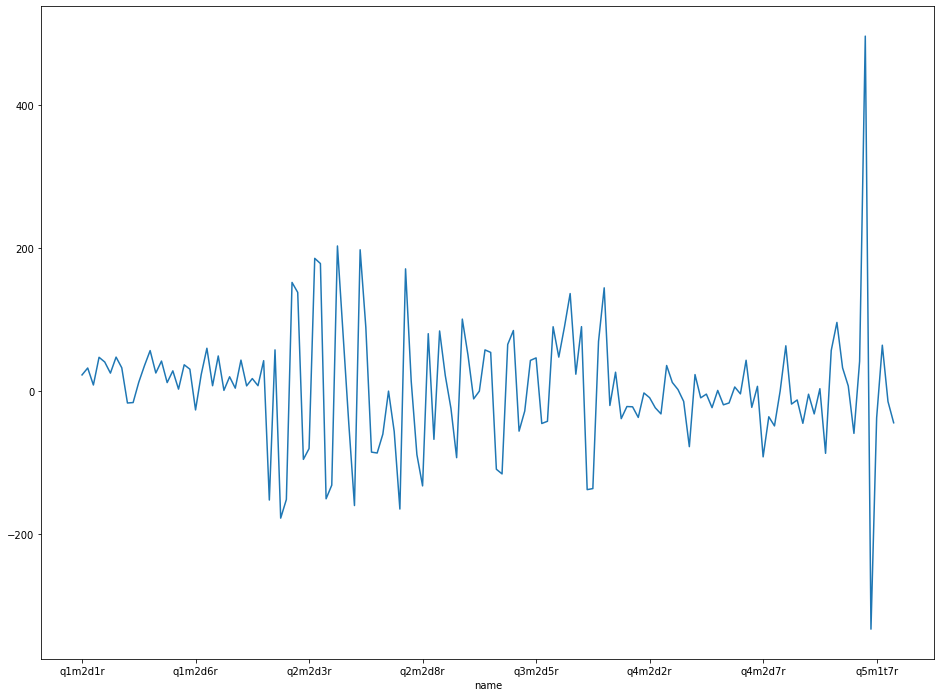

In [70]:
fig, ax = plt.subplots(1, 1 , figsize=[16, 12])
df_lu2.rel.plot()

In [71]:
### Put the strength into the model

In [72]:
for name, val in df_lu.val.items():
    if name == "qit6r":
        # This one is split 
        acc.find(name + 'l', 0).setMainMultipoleStrength(val)
        acc.find(name + 'r', 0).setMainMultipoleStrength(val)
    else:
        acc.find(name, 0).setMainMultipoleStrength(val)
    # print(val)
    # break

In [73]:
from thor_scsi.utils.linear_optics import compute_twiss_along_lattice

In [74]:
ttwiss2 = compute_twiss_along_lattice(acc)
ttwiss2

<xarray.Dataset>
Dimensions:           (index: 1362, plane: 2, par: 3, phase_coordinate: 6)
Coordinates:
  * index             (index) int64 0 1 2 3 4 5 ... 1357 1358 1359 1360 1361
  * plane             (plane) <U1 'x' 'y'
  * par               (par) <U5 'alpha' 'beta' 'dnu'
  * phase_coordinate  (phase_coordinate) <U5 'ct' 'delta' 'px' 'py' 'x' 'y'
Data variables:
    elements          (index) object <thor_scsi::core::CellVoid const* @ 0x47...
    names             (index) <U14 'begin' 'dg9l2d1r' ... 'dg9l1d1r' 'ringend'
    s                 (index) float64 0.0 0.6155 0.6155 ... 239.5 240.0 240.0
    twiss             (index, plane, par) float64 0.09224 16.88 ... -3.262e-18
    dispersion        (index, phase_coordinate) float64 nan nan ... -0.03004 0.0
    tps               (index, phase_coordinate) object cst:
             0
li...

In [75]:
ttwiss = (
    xr.Dataset(dict(beta=ttwiss2.twiss.sel(par="beta")))
    .assign(dict(dmu=ttwiss2.twiss.sel(par="dnu"), ds=ttwiss2.s))
)

ttwiss = ttwiss.assign(mu=ttwiss.dmu.cumsum(dim="index")).rename(index="pos").assign_coords(dict(pos=ttwiss2.names.values))
ttwiss

<xarray.Dataset>
Dimensions:  (pos: 1362, plane: 2)
Coordinates:
  * pos      (pos) <U14 'begin' 'dg9l2d1r' 'm_fomz2d1r' ... 'dg9l1d1r' 'ringend'
  * plane    (plane) <U1 'x' 'y'
    par      <U5 'beta'
Data variables:
    beta     (pos, plane) float64 16.88 3.482 16.79 3.397 ... 3.482 16.88 3.482
    dmu      (pos, plane) float64 2.924e-17 2.924e-17 ... 3.24e-19 -3.262e-18
    ds       (pos) float64 0.0 0.6155 0.6155 1.137 ... 239.5 239.5 240.0 240.0
    mu       (pos, plane) float64 2.924e-17 2.924e-17 0.00582 ... 17.85 6.726

In [76]:
ls

axes_offset.pdf                          catalog_access.ipynb
bba_analysis_dt.ipynb                    inspect_model.ipynb
bba_analysis.ipynb                       __pycache__/
bba_analysis_tunes2.ipynb                Q1_tune_data.pdf
bba_analysis_tunes.ipynb                 Q1_tune_data.png
bba_analysis_tunes.py                    Q2_tune_data.pdf
bba_analysis_tunes.py~                   Q2_tune_data.png
BBA_Classic/                             Q3_tune_data.pdf
bba_classic_data.ipynb                   Q3_tune_data.png
bba_classic.nc                           Q4_tune_data.pdf
bba_data1.nc                             Q4_tune_data.png
bba_data.py                              Q5_tune_data.pdf
bba_data.py~                             Q5_tune_data.png
bessii_twiss_tracy.nc                    quadrupole_calibration_factors.ipynb
bessy2_quad_strength_measured_loco.json  retrieve_lattice.ipynb
bessyii_twiss_thor_scsi.nc               tune_data.nc


In [77]:
ttwiss.to_netcdf('bessyii_twiss_thor_scsi.nc')

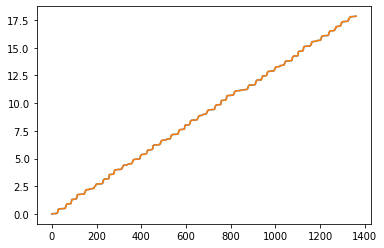

In [235]:
plt.plot(
    ttwiss.mu.sel(plane='x'), '-',
    ttwiss.dmu.sel(plane='x').cumsum(), '-'
        )

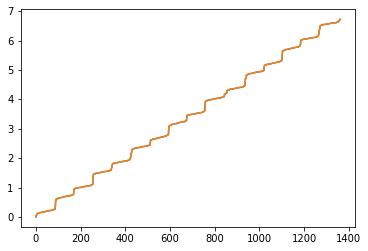

In [237]:
plt.plot(
    ttwiss.mu.sel(plane='y'), '-',
    ttwiss.dmu.sel(plane='y').cumsum(), '-'
)